In [27]:
import pandas as pd
import numpy as np

# Load the files again
customer_df = pd.read_csv('input/Case_Study_Customer_Data.csv')
orders_df = pd.read_csv('input/Case_Study_Orders_Data.csv')

# Step 1: Normalize column names (remove hidden characters, lowercase, replace spaces)
def clean_columns(df):
    df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')  # remove non-ascii
    df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
    return df

customer_df = clean_columns(customer_df)
orders_df = clean_columns(orders_df)

# Step 2: Print columns to confirm
print("Customer Columns:", customer_df.columns.tolist())
print("Orders Columns:", orders_df.columns.tolist())

# Step 3: Ensure there's only one Cust_ID column in each
customer_df = customer_df.loc[:, ~customer_df.columns.duplicated()]
orders_df = orders_df.loc[:, ~orders_df.columns.duplicated()]

# Step 4: Rename to ensure uniformity
customer_df.rename(columns={'Cust_ID': 'Cust_Id'}, inplace=True)
orders_df.rename(columns={'Cust_ID': 'Cust_Id'}, inplace=True)

# Step 5: Parse dates
customer_df['Customer_Created_Date'] = pd.to_datetime(customer_df['Customer_Created_Date'], errors='coerce')
orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'], errors='coerce')

# Step 6: Handle Order Amount and Revenue logic
orders_df['Order_Amount'] = pd.to_numeric(orders_df['Order_Amount'], errors='coerce').fillna(0)
orders_df['Revenue'] = np.where(orders_df['Order_Status'] == 'Won', orders_df['Order_Amount'], 0)

# Step 7: Create Month fields
customer_df['Cust_Month'] = customer_df['Customer_Created_Date'].dt.to_period('M')
orders_df['Order_Month'] = orders_df['Order_Date'].dt.to_period('M')

# Final Step: Merge
merged_df = orders_df.merge(customer_df, on='Cust_Id', how='left')

print(" Merge successful!")
print(merged_df.head())


Customer Columns: ['Cust_Id', 'Customer_Created_Date', 'Week', 'Cust_Profession']
Orders Columns: ['Order_No', 'Cust_ID', 'Order_Date', 'Order_Status', 'Order_Amount', 'Feedback']
 Merge successful!
       Order_No   Cust_Id          Order_Date Order_Status  Order_Amount  \
0  4.260000e+18  6X894534 2001-01-21 00:36:00        Other           0.0   
1  4.260000e+18  0WWO4742 2001-01-21 06:24:00        Other           0.0   
2  4.260000e+18  V4OO4168 2001-01-21 06:47:00        Other           0.0   
3  4.260000e+18  V4OO4168 2001-01-21 06:51:00        Other           0.0   
4  4.260000e+18  Z8EA4622 2001-01-21 09:02:00        Other           0.0   

                                            Feedback  Revenue Order_Month  \
0  My order arrived two weeks late and the box wa...      0.0     2001-01   
1  love the new clothing line, the quality is ama...      0.0     2001-01   
2  The book I wanted was out of stock for weeks. ...      0.0     2001-01   
3  Website is slow and hard to navig

/tmp/ipykernel_8209/3647134746.py:31: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'], errors='coerce')


🎯 Objective 1: Monthly Revenue, Users, Revenue per User

In [28]:
monthly_revenue = merged_df.groupby('Order_Month').agg(
    Revenue=('Revenue', 'sum'),
    Users=('Cust_Id', pd.Series.nunique)
)
monthly_revenue['Revenue per User'] = monthly_revenue['Revenue'] / monthly_revenue['Users']
print(monthly_revenue)


# Count new customers per month
new_customers = customer_df.groupby('Cust_Month').agg(New_Customers=('Cust_Id', 'nunique')).reset_index()
new_customers.rename(columns={'Cust_Month': 'Order_Month'}, inplace=True)  # Align for merge

# Merge with monthly revenue
monthly_analysis = monthly_revenue.reset_index().merge(new_customers, on='Order_Month', how='left')

# Fill missing months with 0
monthly_analysis['New_Customers'] = monthly_analysis['New_Customers'].fillna(0).astype(int)

# Round values
monthly_analysis = monthly_analysis.round(2)
print(monthly_analysis)


              Revenue  Users  Revenue per User
Order_Month                                   
1930-01       28650.0     72        397.916667
1930-03      154717.0     93       1663.623656
1930-04      210715.0     97       2172.319588
1930-05      175151.0    141       1242.205674
1930-06      647531.0    132       4905.537879
...               ...    ...               ...
2029-04      142275.0     75       1897.000000
2029-05      453410.0    111       4084.774775
2029-06      481365.0    121       3978.223140
2029-07      436566.0     73       5980.356164
2029-08       87509.0     41       2134.365854

[253 rows x 3 columns]
    Order_Month   Revenue  Users  Revenue per User  New_Customers
0       1930-01   28650.0     72            397.92              0
1       1930-03  154717.0     93           1663.62              0
2       1930-04  210715.0     97           2172.32              0
3       1930-05  175151.0    141           1242.21              0
4       1930-06  647531.0    132   

In [29]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Shorten the monthly_revenue summary
monthly_summary = monthly_revenue.reset_index()
monthly_summary['Order_Month'] = monthly_summary['Order_Month'].astype(str)
monthly_summary = monthly_summary.round(2)

# Convert to a small tabular string
monthly_text = monthly_summary.to_string(index=False)


# Prompt
prompt = f"""
You are a senior data analyst. Below is a monthly summary of customer and revenue data.

Columns:
- Order_Month: The month being analyzed
- Revenue: Total revenue collected that month
- Users: Unique users who placed orders
- Revenue per User: Revenue divided by number of users
- New_Customers: Number of new customers who signed up that month

Data:
{monthly_text}

Please analyze:
1. Identify trends in revenue, user base, and new customer signups over time.
2. Determine whether growth is driven more by user base expansion or increased revenue per user.
3. Identify months where a spike/drop in new customers led to corresponding change in revenue.
4. Point out any seasonal or behavioral patterns.
5. Recommend 3 data-driven growth strategies that combine insights from customer onboarding and user revenue efficiency.

Make the analysis concise, structured, and suitable for business decision-makers.
"""

# API Call
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Output
print("\n🔍 AI Insight on Monthly Revenue:\n")
print(response.choices[0].message.content)



🔍 AI Insight on Monthly Revenue:

1. Trends over time:
   - Revenue: There are noticeable spikes in revenue at various points, such as in June 1930, May 1931, and August 2028. However, the general trend seems to be an increase in revenue over time, which suggests that the business is growing.
   - User Base: The user base also appears to be growing over time, although there are some months where the number of users dips slightly. Overall, the trend suggests a steady increase in the number of users.
   - New Customer Signups: The data for new customer signups is not provided. 

2. Growth Determination: The growth seems to be driven by both an increase in the user base and increased revenue per user. In many instances, months with a higher number of users also have higher revenue. However, there are also months where the revenue per user is significantly higher, suggesting that the users are spending more.

3. Impact of New Customers on Revenue: Without data on new customer signups, it'

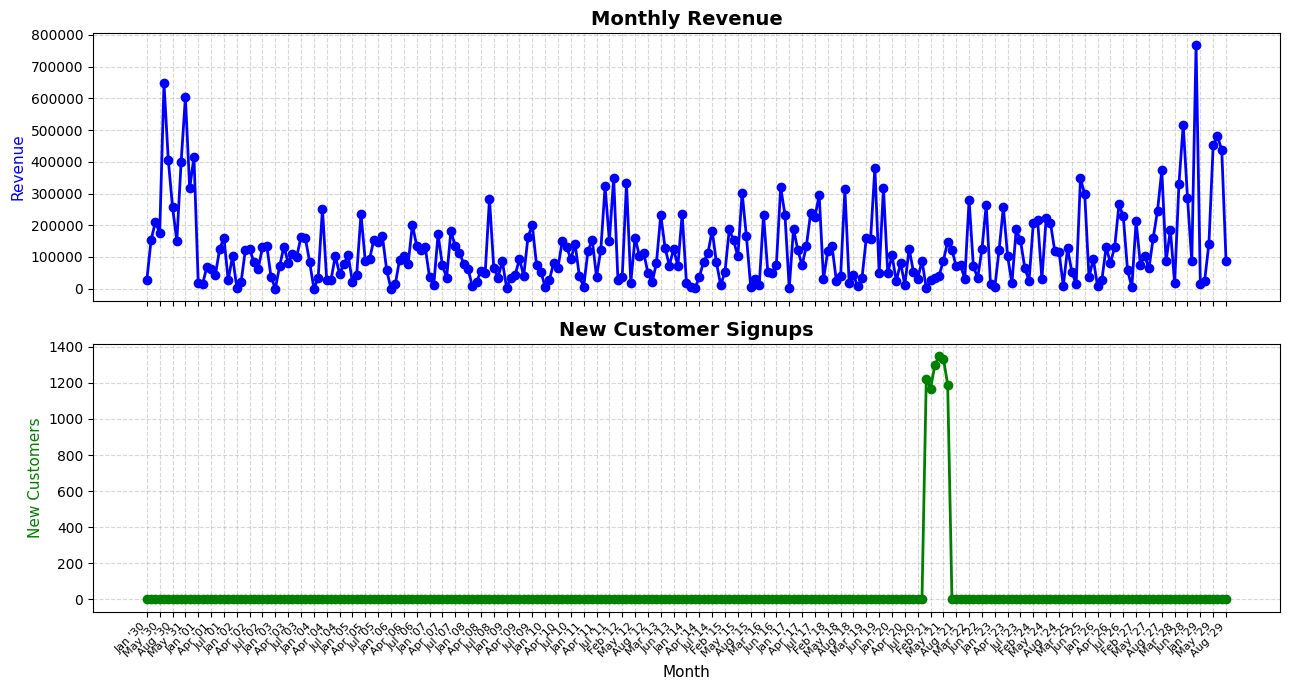

In [30]:
import matplotlib.pyplot as plt

# Format months: Jan '21 instead of Jan 2021
monthly_analysis['Order_Month'] = pd.to_datetime(monthly_analysis['Order_Month'].astype(str)).dt.strftime("%b '%y")
months = monthly_analysis['Order_Month'].tolist()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

# --- Revenue Plot ---
ax1.plot(months, monthly_analysis['Revenue'], color='blue', marker='o', linewidth=2)
ax1.set_title("Monthly Revenue", fontsize=14, fontweight='bold')
ax1.set_ylabel("Revenue", fontsize=11, color='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- New Customers Plot ---
ax2.plot(months, monthly_analysis['New_Customers'], color='green', marker='o', linewidth=2)
ax2.set_title("New Customer Signups", fontsize=14, fontweight='bold')
ax2.set_ylabel("New Customers", fontsize=11, color='green')
ax2.set_xlabel("Month", fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.5)

# Control tick frequency and formatting
tick_interval = 3  # every 3rd month
visible_months = [months[i] for i in range(0, len(months), tick_interval)]

ax2.set_xticks(range(0, len(months), tick_interval))
ax2.set_xticklabels(visible_months, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()


🎯 Objective 2: Users who placed vs converted (by Month & Profession)

In [31]:
# Add a flag for conversion (Revenue > 0)
merged_df['Converted'] = merged_df['Revenue'] > 0

# Now group and count
conversion = merged_df.groupby(['Cust_Month', 'Cust_Profession']).agg(
    Users_Placed_Orders=('Cust_Id', 'nunique'),
    Users_Converted=('Converted', 'sum')  # Since True = 1, False = 0
).reset_index()

print(conversion)

conversion['Conversion_Rate'] = (
    conversion['Users_Converted'] / conversion['Users_Placed_Orders']
).round(2)


   Cust_Month       Cust_Profession  Users_Placed_Orders  Users_Converted
0     2021-01     BFSI Professional                   62               96
1     2021-01              CC Agent                   10                0
2     2021-01      Customer Support                   88               50
3     2021-01         Finance Agent                  196              262
4     2021-01             Homemaker                   16               10
..        ...                   ...                  ...              ...
79    2021-06                Others                   43               16
80    2021-06    Sales Professional                  206               41
81    2021-06        Small Merchant                  146               99
82    2021-06               Student                   83               25
83    2021-06  Working Professional                   20                0

[84 rows x 4 columns]


In [32]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Round and prepare the table for GPT input
conversion_short = conversion.copy()
conversion_short['Cust_Month'] = conversion_short['Cust_Month'].astype(str)
conversion_short = conversion_short.round(2)

# Optional: trim to recent months to save tokens
conversion_short = conversion_short.tail(100)  # or adjust as needed

conversion_text = conversion_short.to_string(index=False)

# GPT prompt
prompt = f"""
You're an AI business analyst. Below is a dataset showing customer conversion performance by month and profession.

Columns:
- Cust_Month: Customer signup month
- Cust_Profession: Profession of the customer
- Users_Placed_Orders: Unique users who placed an order
- Users_Converted: Users who generated revenue (conversion)
- Conversion_Rate: Ratio of converted users to those who placed orders

Data:
{conversion_text}

Please analyze:
1. Which professions show consistently high or low conversion rates?
2. Are there any professions with high order activity but low conversion efficiency?
3. Identify months where conversion rates significantly increased or dropped.
4. Suggest behavioral or product-fit reasons by profession.
5. Recommend how marketing or product teams can act on these trends.

Make your insights concise, data-backed, and actionable for non-technical business decision-makers.
"""


# GPT API Call
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Print results
print("\n🔍 AI Insight on Conversion by Profession and Month:\n")
print(response.choices[0].message.content)



🔍 AI Insight on Conversion by Profession and Month:

1. Consistently High Conversion Rates: Customer Support, Insurance Agent, and Finance Agent professions show consistently high conversion rates across the months. 
   Consistently Low Conversion Rates: CC Agent, Investment Agent, Loan Agent, and Students show consistently low conversion rates.

2. High Order Activity but Low Conversion: Sales Professionals and Network Marketing professions have high order activity but comparatively lower conversion rates.

3. Significant Increase in Conversion Rates: February 2021 saw a significant increase in conversion rates for the Customer Support and Investment Agent professions. 
   Significant Drop in Conversion Rates: April 2021 witnessed a significant drop in conversion rates for BFSI Professionals, Finance Agents, and Insurance Agents.

4. Behavioral or Product-Fit Reasons: 
   - For professions like Customer Support, Insurance Agent, and Finance Agent, the high conversion rates may be due

📈 Profession-wise Conversion Rate Over Months

/tmp/ipykernel_8209/177790032.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rajendra/anaconda3/envs/vip_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


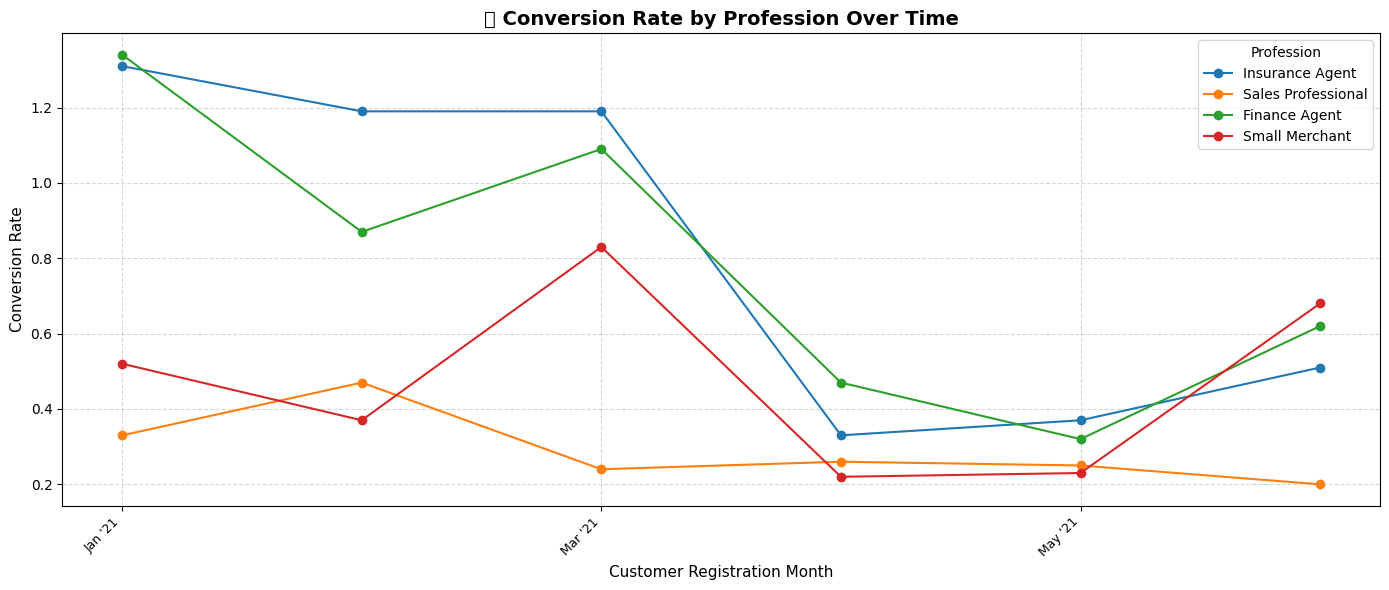

In [33]:
import matplotlib.pyplot as plt

# Prepare data
conversion['Cust_Month'] = pd.to_datetime(conversion['Cust_Month'].astype(str)).dt.strftime("%b '%y")

# Choose top professions by order volume
top_professions = (
    conversion.groupby('Cust_Profession')['Users_Placed_Orders'].sum()
    .sort_values(ascending=False)
    .head(4)
    .index
)

# Filter only those top professions
top_conversion = conversion[conversion['Cust_Profession'].isin(top_professions)]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for profession in top_professions:
    prof_data = top_conversion[top_conversion['Cust_Profession'] == profession]
    ax.plot(prof_data['Cust_Month'], prof_data['Conversion_Rate'], marker='o', label=profession)

ax.set_title("📊 Conversion Rate by Profession Over Time", fontsize=14, fontweight='bold')
ax.set_xlabel("Customer Registration Month", fontsize=11)
ax.set_ylabel("Conversion Rate", fontsize=11)
ax.legend(title='Profession')
ax.grid(True, linestyle='--', alpha=0.5)

# Clean x-axis
tick_interval = 2
months = prof_data['Cust_Month'].tolist()
ax.set_xticks(range(0, len(months), tick_interval))
ax.set_xticklabels(months[::tick_interval], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()


🎯 Objective 3: Feedback Sentiment (by Month and Purchase Status)

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return 'Neutral'
    score = sia.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['Sentiment'] = merged_df['Feedback'].apply(get_sentiment)

# Purchased vs Not Purchased
merged_df['Purchased'] = np.where(merged_df['Revenue'] > 0, 'Purchased', 'Not Purchased')

# Group by Month + Purchase status + Sentiment
sentiment_summary = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().unstack(fill_value=0)

print(sentiment_summary)


Sentiment                  Negative  Neutral  Positive
Order_Month Purchased                                 
1930-01     Not Purchased        23       28        41
            Purchased             7        1         4
1930-03     Not Purchased        22       42        50
            Purchased             3        5         4
1930-04     Not Purchased        25       38        45
...                             ...      ...       ...
2029-06     Purchased             9        6        16
2029-07     Not Purchased        23       25        44
            Purchased            10        8        12
2029-08     Not Purchased        13        7        19
            Purchased             4        7         7

[504 rows x 3 columns]


In [35]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Ensure 'sentiment_summary' is a DataFrame
sentiment_summary = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().unstack(fill_value=0)

# Limit rows to reduce token usage
sentiment_summary_trimmed = sentiment_summary.tail(100)  # Adjust if needed

# Convert index to string to avoid formatting errors
sentiment_summary_trimmed.index = sentiment_summary_trimmed.index.map(str)

# Convert to string after trimming
sentiment_text = sentiment_summary_trimmed.to_string()

# GPT prompt
prompt = f"""
You're an AI sentiment and customer behavior analyst.

Below is a dataset grouped by:
- Order Month
- Purchase Status ('Purchased' or 'Not Purchased')
- Sentiment Category ('Positive', 'Neutral', 'Negative')

Each value shows the number of feedback instances matching that category.

Data:
{sentiment_text}

Instructions:
1. Identify trends in sentiment across customers who purchased vs not purchased.
2. Highlight months where negative sentiment among 'Not Purchased' customers spiked.
3. Suggest reasons why positive sentiment might not correlate with purchases in certain periods.
4. Recommend product/UX or communication improvements based on customer sentiment patterns.

Keep the response structured and action-focused.
"""

# Call the API
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Output the AI-generated insights
print("\n🧠 AI Insight on Sentiment vs Purchase Behavior:\n")
print(response.choices[0].message.content)



🧠 AI Insight on Sentiment vs Purchase Behavior:

1. Trends in Sentiment:

   Across the dataset, there is a clear trend where customers who did not purchase have a higher volume of feedback in all sentiment categories (positive, neutral, negative). This might indicate a higher level of engagement or dissatisfaction among those customers. However, the ratio of negative to positive feedback is generally higher among customers who did not purchase, indicating a higher level of dissatisfaction.

2. Negative Sentiment Spikes:

   There are several months where negative sentiment among 'Not Purchased' customers spiked. These include June 2023, February 2024, April 2024, May 2024, February 2025, May 2025, May 2026, January 2027, May 2027, and May 2029. These spikes might be due to changes in the product, pricing, or external factors affecting customer sentiment.

3. Positive Sentiment and Purchases:

   There are several periods where positive sentiment did not correlate with purchases. For 

📊 Stacked Bar Chart: Sentiment by Month and Purchase Status

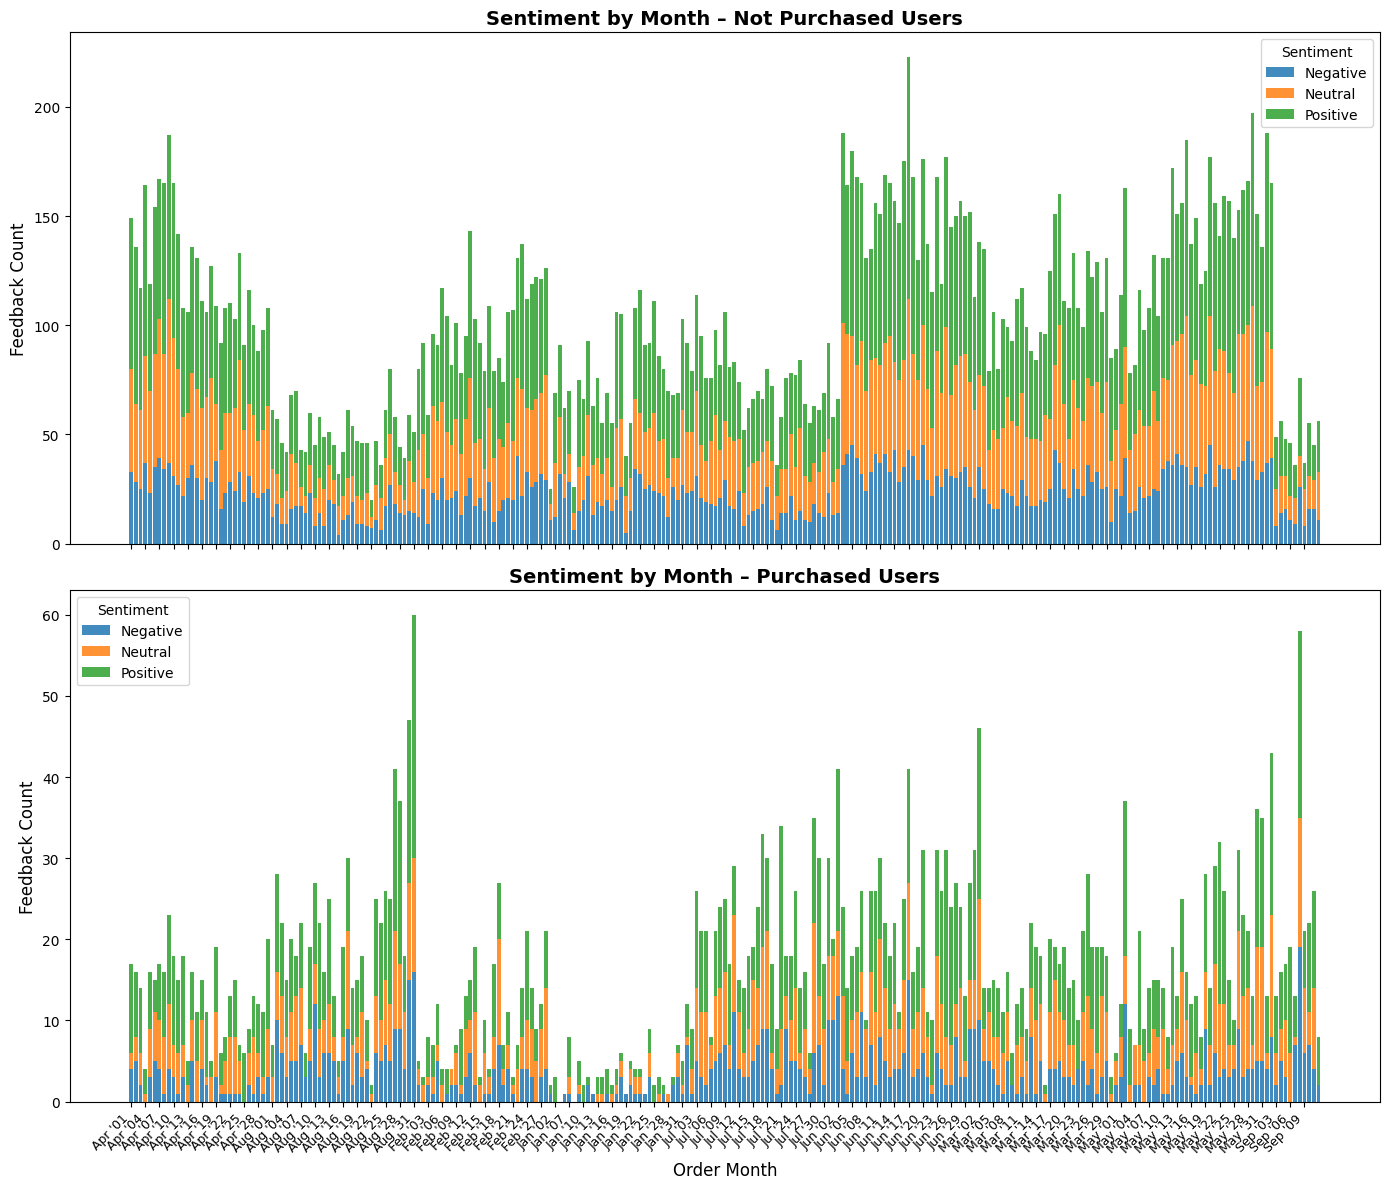

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare sentiment summary
sentiment_df = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().reset_index(name='Count')

# Step 2: Pivot for plotting
pivot_df = sentiment_df.pivot_table(index=['Order_Month', 'Purchased'], 
                                     columns='Sentiment', 
                                     values='Count', 
                                     fill_value=0).reset_index()

# Step 3: Format Order_Month to "Jan '24"
pivot_df['Order_Month'] = pd.to_datetime(pivot_df['Order_Month'].astype(str)).dt.strftime("%b '%y")

# Step 4: Plotting with spacing
purchase_groups = pivot_df['Purchased'].unique()
fig, axes = plt.subplots(len(purchase_groups), 1, figsize=(14, 6 * len(purchase_groups)), sharex=True)

if len(purchase_groups) == 1:
    axes = [axes]  # ensure iterable

for i, status in enumerate(purchase_groups):
    data = pivot_df[pivot_df['Purchased'] == status].sort_values(by='Order_Month')
    months = data['Order_Month'].tolist()

    # Plot each sentiment as stacked bar
    bottom = None
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        axes[i].bar(months, data[sentiment], label=sentiment, bottom=bottom, alpha=0.85)
        bottom = data[sentiment] if bottom is None else bottom + data[sentiment]

    axes[i].set_title(f"Sentiment by Month – {status} Users", fontsize=14, fontweight='bold')
    axes[i].set_ylabel("Feedback Count", fontsize=12)
    axes[i].legend(title="Sentiment")
    
    # Show every 3rd month to reduce overcrowding
    tick_interval = 3
    visible_ticks = range(0, len(months), tick_interval)
    axes[i].set_xticks(visible_ticks)
    axes[i].set_xticklabels([months[i] for i in visible_ticks], rotation=45, ha='right', fontsize=9)

plt.xlabel("Order Month", fontsize=12)
plt.tight_layout()
plt.show()


🎯 Objective 4: Monthly Cohort Analysis

In [37]:

# Step 1: Assign cohort month from customer registration
cohort = customer_df[['Cust_Id', 'Cust_Month']].rename(columns={'Cust_Month': 'Cohort_Month'})

# Step 2: Merge with order data
orders_with_cohort = orders_df.merge(cohort, on='Cust_Id', how='left')

# Step 3: Create Order_Month if not already
orders_with_cohort['Order_Month'] = orders_with_cohort['Order_Date'].dt.to_period('M')

# Step 4: Compute Cohort Index
orders_with_cohort['Cohort_Index'] = (
    (orders_with_cohort['Order_Month'].dt.year - orders_with_cohort['Cohort_Month'].dt.year) * 12 +
    (orders_with_cohort['Order_Month'].dt.month - orders_with_cohort['Cohort_Month'].dt.month)
) + 1

# Step 5: Create cohort table
cohort_table = orders_with_cohort[orders_with_cohort['Order_Status'] == 'Won'].groupby(
    ['Cohort_Month', 'Order_Month']
).agg(Revenue=('Order_Amount', 'sum')).unstack(fill_value=0)

# Step 6: Fix column names
cohort_table.columns = [f"Revenue in {m[1].strftime('%b %Y')}" for m in cohort_table.columns]

# Step 7: Cleanup
cohort_table.index.name = None
cohort_table = cohort_table.reset_index()

print(cohort_table)

     index  Revenue in Jan 1930  Revenue in Mar 1930  Revenue in Apr 1930  \
0  2021-01              28650.0              31003.0              53186.0   
1  2021-02                  0.0                  0.0              56094.0   
2  2021-03                  0.0             123714.0              84436.0   
3  2021-04                  0.0                  0.0              16999.0   
4  2021-05                  0.0                  0.0                  0.0   
5  2021-06                  0.0                  0.0                  0.0   

   Revenue in May 1930  Revenue in Jun 1930  Revenue in Jul 1930  \
0               1458.0             126362.0               5892.0   
1              39309.0             181906.0             360862.0   
2              38267.0             219678.0              33329.0   
3              40949.0              12903.0               2818.0   
4              55168.0              36210.0               3801.0   
5                  0.0              70472.0         

In [38]:
import os
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Ensure index is clean
if 'Cohort_Month' in cohort_table.columns:
    cohort_table.set_index('Cohort_Month', inplace=True)

# Convert index to timestamp if Period type
if isinstance(cohort_table.index[0], pd.Period):
    cohort_table.index = cohort_table.index.to_timestamp()

# If columns have Periods, convert to string
cohort_table.columns = [
    col.strftime('%b %Y') if isinstance(col, pd.Period) else col for col in cohort_table.columns
]

# Round revenue values
cohort_table = cohort_table.round(2)

# Select only numeric columns for stats
numeric_data = cohort_table.select_dtypes(include='number')

# Compute stats on numeric data only
summary_stats = numeric_data.agg(['mean', 'std']).T.round(2).head(10).to_string()

# Top and bottom cohorts by revenue
total_revenue = numeric_data.sum(axis=1).sort_values(ascending=False)
top_cohorts = total_revenue.head(3)
bottom_cohorts = total_revenue.tail(3)

top_summary = top_cohorts.to_string()
bottom_summary = bottom_cohorts.to_string()

# Build AI prompt
prompt = f"""
You're an AI data analyst.

You are analyzing cohort-wise revenue, where each row represents a signup month and each column shows revenue in the following months.

### Sample Summary Stats (Mean and Std of Revenue per month):
{summary_stats}

### Top 3 Cohorts by Total Revenue:
{top_summary}

### Bottom 3 Cohorts by Total Revenue:
{bottom_summary}

Give a concise analysis of:
1. Revenue retention patterns
2. Key trends differentiating top and bottom cohorts
3. AI-based suggestions to improve cohort revenue
4. Anomalies or outliers that require attention
"""

# ✅ Call GPT-4 API
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Show results
print("\n🔍 AI Insight:")
print(response.choices[0].message.content)



🔍 AI Insight:
1. Revenue Retention Patterns: 
The revenue seems to fluctuate over the months. There is a significant increase in revenue in June 1930, which then drops in July but still remains higher than the preceding months. This pattern suggests that there might be some seasonality or specific events influencing the revenue. Also, it is noticeable that the revenue in the first month of the year (January) is significantly lower than in later months. This could be due to post-holiday effects where customers might be less likely to spend.

2. Key Trends Differentiating Top and Bottom Cohorts:
The top cohorts have significantly higher total revenue than the bottom cohorts. This could be due to a number of factors including better customer retention, more effective marketing strategies, or a larger customer base. The standard deviation of revenue is also generally higher in the top cohorts, suggesting that their revenue is more volatile and potentially more influenced by high-value cus

In [39]:
import pandas as pd

with pd.ExcelWriter("cohort_analysis_report.xlsx", engine='openpyxl') as writer:
    cohort_table.to_excel(writer, sheet_name='cohort_table', index=False)
    cohort_table.describe().to_excel(writer, sheet_name='summary_stats')
    conversion.to_excel(writer, sheet_name='conversion', index=False)
    sentiment_summary.to_excel(writer, sheet_name='sentiment', index=True)
    monthly_revenue.to_excel(writer, sheet_name='monthly_revenue', index=True)